In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
concrete = pd.read_csv('data/concrete.csv')
co2 = pd.read_csv('data/co2.csv')

concrete['co2_lower'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'lower_bound'].values[0] for col in concrete.columns[:7]])
concrete['co2_upper'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'upper_bound'].values[0] for col in concrete.columns[:7]])

concrete = concrete[concrete['age'] < 120]

concrete_as = concrete[(concrete['ash'] > 0) & (concrete['slag'] > 0)]
concrete_a = concrete[(concrete['ash'] > 0) & (concrete['slag'] == 0)]
concrete_s = concrete[(concrete['ash'] == 0) & (concrete['slag'] > 0)]
concrete_ = concrete[(concrete['ash'] == 0) & (concrete['slag'] == 0)]

concrete_train, concrete_test = train_test_split(concrete,
                                                 shuffle=True,
                                                 random_state=487)

features = concrete.columns[:-3]

In [78]:
from xgboost import XGBRegressor

In [4]:
reg_for = RandomForestRegressor(n_estimators=300, max_depth=15)

reg_for.fit(concrete_train[features],concrete_train['strength'])

RandomForestRegressor(max_depth=15, n_estimators=300)

In [96]:
best_params = {'max_depth': 2, 'n_estimators': 1760, 'tree_method': 'approx', 'learning_rate': .15}
best_model = XGBRegressor(max_depth=best_params['max_depth'],
                        n_estimators=best_params['n_estimators'],
                        tree_method=best_params['tree_method'],
                        learning_rate=best_params['learning_rate'])
best_model.fit(concrete_train[features], concrete_train['strength'])
concrete_train['predict'] = best_model.predict(concrete_train[features])
concrete_test['exp_age'] = np.exp(-.038 * concrete_test['age'])
concrete_test['predict'] = best_model.predict(concrete_test[features])

mean_squared_error(concrete_test['strength'], concrete_test['predict'])

18.871914281687182

In [58]:
def co2_from_data(the_data):
    co22 = pd.read_csv('data/co2.csv')
    return sum([the_data[col] * co22.loc[co22.ingredient == col, 'lower_bound'].values[0] for col in the_data.columns[:7]])

def co2_from_data2(the_data):
    co22 = pd.read_csv('data/co2.csv')
    return sum(the_data[i]*co22['upper_bound'].loc[i] for i in range(7))

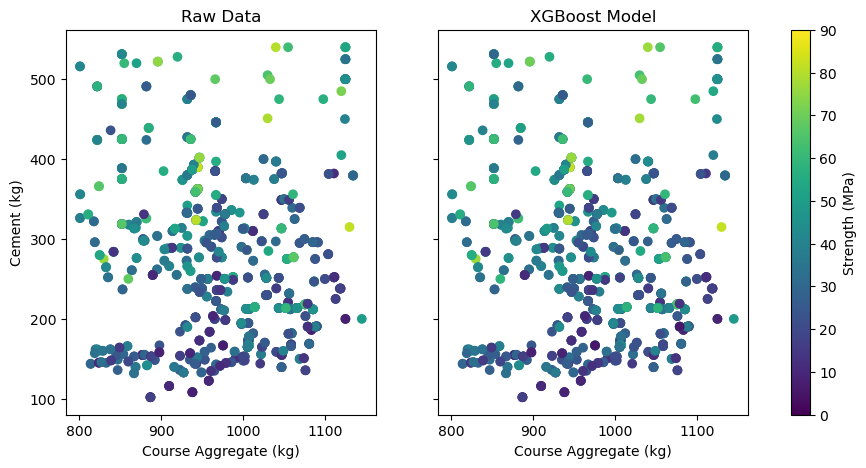

In [89]:
fig, ax = plt.subplots(1,2,sharey=True)
ax[0].scatter(concrete['coarseagg'],concrete['cement'],c=concrete['strength'],vmin=0,vmax=90)
ax[0].set_ylabel('Cement (kg)')
ax[0].set_title('Raw Data')
ax[0].set_xlabel('Course Aggregate (kg)')
here = ax[1].scatter(concrete['coarseagg'],concrete['cement'],c=best_model.predict(concrete[features]),vmin=0,vmax=90)
fig.colorbar(here,ax=ax,label='Strength (MPa)')
ax[1].set_title('XGBoost Model')
ax[1].set_xlabel('Course Aggregate (kg)')
fig.set_size_inches(11,5)
#fig.tight_layout()
plt.show()

In [83]:
water_density = 997 
cement_density = 2400
fine_density = 1602 
course_density = 1750 

par_slag = 0
par_ash = 0
par_water = 220
par_super = 0

par_fine = 800
par_age = 120

xnum = 50
ynum = 100
course_grid = np.linspace(800,1200,num=xnum)
cement_grid = np.linspace(100,600,num=ynum)
strength_grid = np.zeros((ynum,xnum))
co2_grid = np.zeros((ynum,xnum))
for i in range(xnum):
    for j in range(ynum):
        fake_panda = pd.DataFrame([[cement_grid[j],par_slag,par_ash,water_density*(1 - cement_grid[j]/cement_density - course_grid[i]/course_density - par_fine/fine_density),par_super,course_grid[i],par_fine,par_age]],columns=features)
        strength_grid[j,i] = best_model.predict(fake_panda)
        co2_grid[j,i] = co2_from_data(fake_panda)

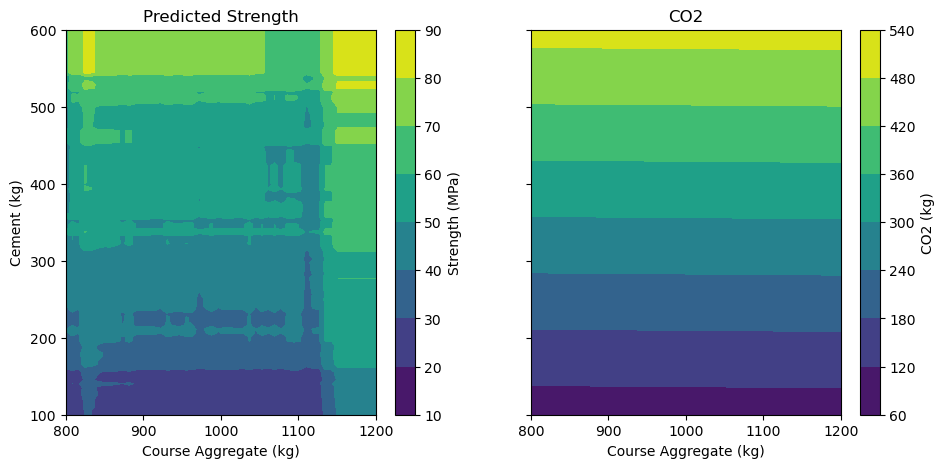

In [84]:
fig, ax = plt.subplots(1,2,sharey=True)
here0 = ax[0].contourf(course_grid,cement_grid,strength_grid)
ax[0].set_ylabel('Cement (kg)')
ax[0].set_title('Predicted Strength')
ax[0].set_xlabel('Course Aggregate (kg)')
plt.colorbar(here0,ax=ax[0],label='Strength (MPa)')
here1 = ax[1].contourf(course_grid,cement_grid,co2_grid)
plt.colorbar(here1,ax=ax[1],label='CO2 (kg)')
ax[1].set_title('CO2')
ax[1].set_xlabel('Course Aggregate (kg)')
fig.set_size_inches(11,5)
#fig.tight_layout()
plt.show()

In [90]:
water_density = 997 
cement_density = 2400
fine_density = 1602 
course_density = 1750 

par_slag = 0
par_ash = 0
par_water = 220
par_super = 0

par_fine = 800
par_age = 120

xnum = 50
ynum = 100
water_grid = np.linspace(150,210,num=xnum)
cement_grid = np.linspace(100,600,num=ynum)
strength_grid2 = np.zeros((ynum,xnum))
co2_grid2 = np.zeros((ynum,xnum))
for i in range(xnum):
    for j in range(ynum):
        fake_panda = pd.DataFrame([[cement_grid[j],par_slag,par_ash,water_grid[i],par_super,course_density*(1 - cement_grid[j]/cement_density - water_grid[i]/water_density - par_fine/fine_density),par_fine,par_age]],columns=features)
        strength_grid2[j,i] = best_model.predict(fake_panda)
        co2_grid2[j,i] = co2_from_data(fake_panda)

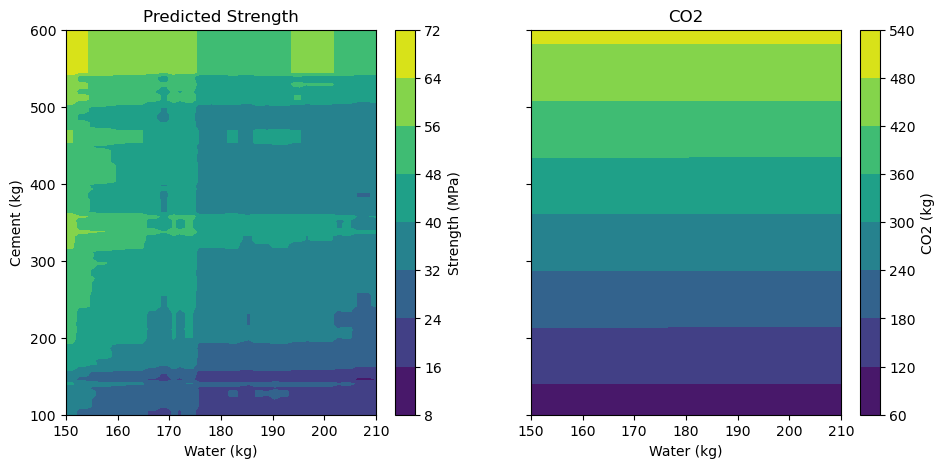

In [91]:
fig, ax = plt.subplots(1,2,sharey=True)
here0 = ax[0].contourf(water_grid,cement_grid,strength_grid2)
ax[0].set_ylabel('Cement (kg)')
ax[0].set_title('Predicted Strength')
ax[0].set_xlabel('Water (kg)')
plt.colorbar(here0,ax=ax[0],label='Strength (MPa)')
here1 = ax[1].contourf(water_grid,cement_grid,co2_grid2)
plt.colorbar(here1,ax=ax[1],label='CO2 (kg)')
ax[1].set_title('CO2')
ax[1].set_xlabel('Water (kg)')
fig.set_size_inches(11,5)
#fig.tight_layout()
plt.show()

In [85]:
concrete.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,co2_lower,co2_upper
count,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000
mean,277.916322,75.007851,57.659091,179.753409,6.602066,972.789979,777.558988,32.243802,35.297562,237.298901,292.075317
std,104.173542,86.782006,64.481653,20.234278,5.945457,78.760530,76.819361,28.242166,16.901546,84.966986,84.851397
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000,94.449400,144.982600
25%,190.300000,0.000000,0.000000,164.800000,0.000000,931.200000,739.300000,7.000000,22.922500,164.954312,221.600260
50%,260.450000,23.000000,0.000000,182.000000,7.000000,968.000000,780.100000,28.000000,33.550000,222.969205,276.505810
75%,350.000000,145.000000,118.375000,192.000000,10.400000,1030.250000,825.000000,28.000000,45.702500,295.027050,348.562218
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,100.000000,82.600000,451.350750,508.773440


In [93]:
concrete[(concrete['cement'] < 300) & (concrete['water'] < 170) & (concrete['ash'] == 0) & (concrete['slag'] == 0)]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,co2_lower,co2_upper
